In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import beta

import warnings
# Filter out all warnings
warnings.filterwarnings('ignore', category=Warning)

In [25]:
df = pd.read_csv('/Users/peter/Documents/Data Science/Waterfall/Chris Copy Impressions + Conversions - Sheet1.csv')
#Convert the 'TOTAL_AD_SPEND' and 'REVENUE_PER_BRAND_IMPRESSION' columns from dollar format to float
df['TOTAL_AD_SPEND'] = df['TOTAL_AD_SPEND'].replace('[\$,]', '', regex=True).astype(float)
df['REVENUE_PER_BRAND_IMPRESSION'] = df['REVENUE_PER_BRAND_IMPRESSION'].replace('[\$,]', '', regex=True).astype(float)
#Convert the 'CVR' column from percentage format to float
df['CVR'] = df['CVR'].replace('[\%,]', '', regex=True).astype(float)/100
#Remove the row where 'BRAND_IMPRESSIONS' is 'd'
df = df[df.BRAND_IMPRESSIONS != 'd']
#Convert the 'BRAND_IMPRESSIONS' column from string to int
df['BRAND_IMPRESSIONS'] = df['BRAND_IMPRESSIONS'].astype(int)
df.head()

,PUBLISHER,BRAND_NAME,DISPLAY_CUSTOMER_TYPE,DISTINCT_MERCHANTS_AT_LOAD_TIME,ML_MODEL,BRAND_IMPRESSIONS,CONV_COUNT,TOTAL_AD_SPEND,REVENUE_PER_BRAND_IMPRESSION,CVR
0,Laura Geller,Dr. Squatch,returning_customer,4,bert4recs1,156,7,7.0,0.0449,0.044872
1,Laura Geller,Caden Lane,returning_customer,4,bert4recs1,156,6,120.0,0.7692,0.038462
2,Laura Geller,Sol de Janeiro,returning_customer,1,boost5,368,14,140.0,0.3804,0.038043
3,Laura Geller,Kopari,returning_customer,3,boost5,128,4,120.0,0.9375,0.031250
4,Laura Geller,Dollar Shave Club,returning_customer,4,bert4recs1,112,3,15.0,0.1339,0.026786


In [71]:
#Aggregate the data 
df_agg = df.groupby(['PUBLISHER', 'BRAND_NAME', 'DISPLAY_CUSTOMER_TYPE', 'DISTINCT_MERCHANTS_AT_LOAD_TIME', 'ML_MODEL'], as_index=False).sum()
df_agg['CVR'] = df_agg['CONV_COUNT'] / df_agg['BRAND_IMPRESSIONS']
df_agg['REVENUE_PER_BRAND_IMPRESSION'] = df_agg['TOTAL_AD_SPEND'] / df_agg['BRAND_IMPRESSIONS']
df_agg.head()

,PUBLISHER,BRAND_NAME,DISPLAY_CUSTOMER_TYPE,DISTINCT_MERCHANTS_AT_LOAD_TIME,ML_MODEL,BRAND_IMPRESSIONS,CONV_COUNT,TOTAL_AD_SPEND,REVENUE_PER_BRAND_IMPRESSION,CVR
0,120/Life,Dr. Squatch,new_customer,0,contextual,145,0,0.0,0.000000,0.000000
1,120/Life,Dr. Squatch,new_customer,1,bert4recs1,101,1,25.0,0.247525,0.009901
2,120/Life,Laura Geller,new_customer,1,bert4recs1,217,1,15.0,0.069124,0.004608
3,120/Life,Laura Geller,new_customer,1,boost5,148,0,0.0,0.000000,0.000000
4,120/Life,Lunya,new_customer,1,boost5,358,0,0.0,0.000000,0.000000


## Heatmap

In [28]:
df.ML_MODEL.unique()

array(['bert4recs1', 'boost5', nan, 'lookalike', 'contextual'],
      dtype=object)

In [87]:
#Create filter variables
model_filter = 'bert4recs1'
customer_type_filter = 'new_customer'
#Apply these filters based on the appropriate columns
df_agg_filter = df_agg[(df_agg['ML_MODEL'] == model_filter) & (df_agg['DISPLAY_CUSTOMER_TYPE'] == customer_type_filter)]
df_agg_filter = df_agg_filter[['PUBLISHER', 'BRAND_NAME', 'TOTAL_AD_SPEND', 'BRAND_IMPRESSIONS', 'CONV_COUNT']]
df_agg_filter = df_agg_filter.groupby(['PUBLISHER', 'BRAND_NAME'], as_index=False).sum()
df_agg_filter['RPL'] = df_agg_filter['TOTAL_AD_SPEND'] / df_agg_filter['BRAND_IMPRESSIONS']
df_agg_filter.sample(5)

,PUBLISHER,BRAND_NAME,TOTAL_AD_SPEND,BRAND_IMPRESSIONS,CONV_COUNT,RPL
494,Mario Badescu Skin Care,Laura Geller,30.0,2217,2,0.013532
882,Wolf & Shepherd,BlendJet,0.0,612,0,0.000000
770,Thorlos,True Classic,0.0,793,0,0.000000
912,jane iredale,Thorlos,0.0,114,0,0.000000
194,Dagne Dover,Little Words Project,0.0,1701,0,0.000000


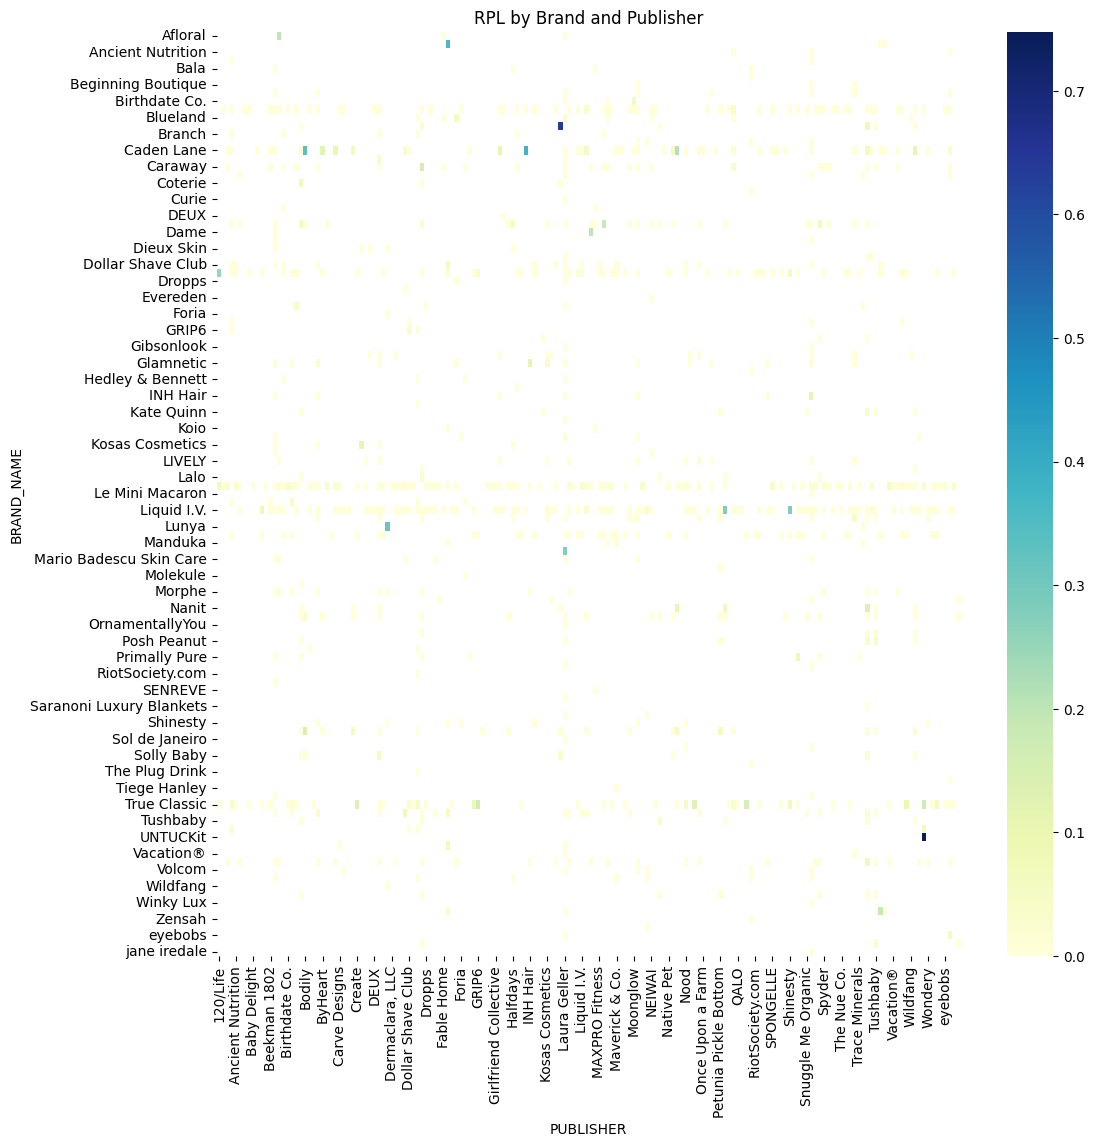

In [107]:
# Pivot the DataFrame to format suitable for heatmap
pivot_table = df_agg_filter.pivot_table(index="BRAND_NAME", columns="PUBLISHER", values="RPL", aggfunc="sum")

# Plotting the heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(pivot_table, cmap="YlGnBu")
plt.title('RPL by Brand and Publisher')
plt.show()

## Bayesian Analysis

In [89]:
#Test this approach with a single brand
# Step 1: Identify the publisher with the highest total BRAND_IMPRESSIONS
top_publisher = df_agg_filter.groupby('PUBLISHER')['BRAND_IMPRESSIONS'].sum().idxmax()

# Filter df for the top publisher
df_top_pub = df_agg_filter[df_agg_filter['PUBLISHER'] == top_publisher]

df_top_pub.sort_values('RPL', ascending=False).head(5)

,PUBLISHER,BRAND_NAME,TOTAL_AD_SPEND,BRAND_IMPRESSIONS,CONV_COUNT,RPL
416,Laura Geller,MantraBand,35.0,125,1,0.280000
396,Laura Geller,Blueland,66.0,1932,2,0.034161
413,Laura Geller,Kopari,105.0,6571,3,0.015979
426,Laura Geller,Ursa Major,30.0,3477,1,0.008628
409,Laura Geller,Glamnetic,30.0,4326,1,0.006935


/var/folders/nn/ckstnx1110j6y5fknhgmvlvr0000gn/T/ipykernel_77570/1834367058.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_pub['Posterior Mean'] = (df_top_pub['CONV_COUNT'] + prior_alpha) / \


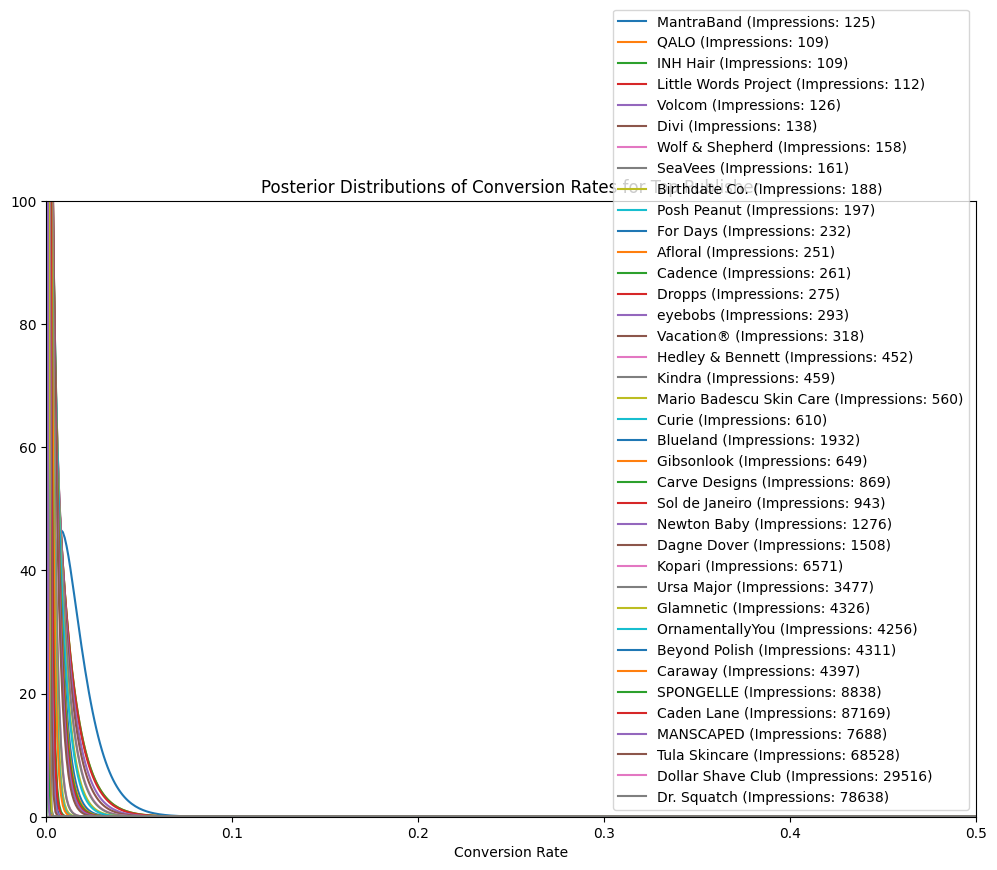

In [102]:
# Step 2: For each brand, calculate the posterior mean of the conversion rate
prior_alpha = 1
prior_beta = 1

df_top_pub['Posterior Mean'] = (df_top_pub['CONV_COUNT'] + prior_alpha) / \
                               (df_top_pub['BRAND_IMPRESSIONS'] + prior_alpha + prior_beta)

# Rank brands by the posterior mean of the conversion rate
df_top_pub_sorted = df_top_pub.sort_values(by='Posterior Mean', ascending=False)

# Display the ranked brands
df_top_pub_sorted[['BRAND_NAME', 'Posterior Mean']]

# Assuming df_top_pub_sorted contains the relevant data for the top publisher
# Calculate Beta distribution parameters
df_top_pub_sorted['alpha'] = df_top_pub_sorted['CONV_COUNT'] + prior_alpha
df_top_pub_sorted['beta'] = df_top_pub_sorted['BRAND_IMPRESSIONS'] - df_top_pub_sorted['CONV_COUNT'] + prior_beta

# Plot Beta distributions
x = np.linspace(0, 1, 1000)  # Range of possible conversion rates
plt.figure(figsize=(12, 8))

for _, row in df_top_pub_sorted.iterrows():
    y = beta.pdf(x, row['alpha'], row['beta'])
    plt.plot(x, y, label=f"{row['BRAND_NAME']} (Impressions: {row['BRAND_IMPRESSIONS']})")

plt.title('Posterior Distributions of Conversion Rates for Top Publisher')
plt.xlabel('Conversion Rate')
#plt.ylabel('Density')
plt.ylim(0, 100)
plt.xlim(0, 0.5)
plt.legend()
plt.show()

In [94]:
#Monte Carlo Simulation Methodology 
# Number of simulations
n_simulations = 100000
simulated_data = np.zeros((len(df_top_pub_sorted), n_simulations))

for i, (index, row) in enumerate(df_top_pub_sorted.iterrows()):
    simulated_data[i, :] = beta.rvs(row['alpha'], row['beta'], size=n_simulations)

# Calculate the number of times each brand has the highest conversion rate
wins = (simulated_data == simulated_data.max(axis=0)).sum(axis=1)

# Calculate the probability of being the best for each brand
df_top_pub_sorted['POB'] = wins / n_simulations

# Display the results
df_top_pub_sorted[['BRAND_NAME', 'POB', 'Posterior Mean', 'BRAND_IMPRESSIONS']].sort_values(by='POB', ascending=False)

,BRAND_NAME,POB,Posterior Mean,BRAND_IMPRESSIONS
416,MantraBand,0.31552,0.015748,125
421,QALO,0.11185,0.009009,109
411,INH Hair,0.11167,0.009009,109
414,Little Words Project,0.10783,0.008772,112
428,Volcom,0.08220,0.007812,126
403,Divi,0.06661,0.007143,138
429,Wolf & Shepherd,0.04654,0.006250,158
423,SeaVees,0.04564,0.006135,161
395,Birthdate Co.,0.02844,0.005263,188
420,Posh Peanut,0.02641,0.005025,197


In [96]:
from scipy.stats import beta
import numpy as np

# Assuming df_top_pub_sorted is already sorted by brand impressions
top_two_brands = df_top_pub_sorted.head(2)

# Extracting Beta parameters for the top two brands
alpha_1, beta_1 = top_two_brands.iloc[0]['alpha'], top_two_brands.iloc[0]['beta']
alpha_2, beta_2 = top_two_brands.iloc[1]['alpha'], top_two_brands.iloc[1]['beta']

# Define a range of conversion rates for evaluation
x = np.linspace(0, 1, 10000)

# Calculate the PDFs for both distributions
pdf_1 = beta.pdf(x, alpha_1, beta_1)
pdf_2 = beta.pdf(x, alpha_2, beta_2)

# Estimate "probability of being better" for brand 1 over brand 2
# This is a simplified approach by calculating the portion where pdf_1 > pdf_2
prob_being_better = np.trapz(np.where(pdf_1 > pdf_2, pdf_1, 0), x) / np.trapz(pdf_1, x)

brand1 = top_two_brands.iloc[0]['BRAND_NAME']
brand2 = top_two_brands.iloc[1]['BRAND_NAME']

print(f"Probability of {brand1} being better than {brand2}: {prob_being_better:.4f}")


Probability of MantraBand being better than QALO: 0.7398


In [110]:
#Use RPL instead of conversion rate
# Calculate Revenue Per Conversion (RPC) for each brand
df_top_pub['RPC'] = df_top_pub['TOTAL_AD_SPEND'] / df_top_pub['CONV_COUNT']

# Assuming prior_alpha and prior_beta have been defined
df_top_pub['alpha'] = df_top_pub['CONV_COUNT'] + prior_alpha
df_top_pub['beta'] = df_top_pub['BRAND_IMPRESSIONS'] - df_top_pub['CONV_COUNT'] + prior_beta

# Calculate the mean of the Beta distribution for each brand (mean CR)
df_top_pub['Mean CR'] = df_top_pub['alpha'] / (df_top_pub['alpha'] + df_top_pub['beta'])

# Estimate RPL as the product of Mean CR and RPC
df_top_pub['Estimated RPL'] = df_top_pub['Mean CR'] * df_top_pub['RPC']
df_top_pub.sort_values('Estimated RPL', ascending=False).head(5)

,PUBLISHER,BRAND_NAME,TOTAL_AD_SPEND,BRAND_IMPRESSIONS,CONV_COUNT,RPL,Posterior Mean,RPC,alpha,beta,Mean CR,Estimated RPL
416,Laura Geller,MantraBand,35.0,125,1,0.280000,0.015748,35.0,2,125,0.015748,0.551181
396,Laura Geller,Blueland,66.0,1932,2,0.034161,0.001551,33.0,3,1931,0.001551,0.051189
413,Laura Geller,Kopari,105.0,6571,3,0.015979,0.000609,35.0,4,6569,0.000609,0.021299
426,Laura Geller,Ursa Major,30.0,3477,1,0.008628,0.000575,30.0,2,3477,0.000575,0.017246
409,Laura Geller,Glamnetic,30.0,4326,1,0.006935,0.000462,30.0,2,4326,0.000462,0.013863


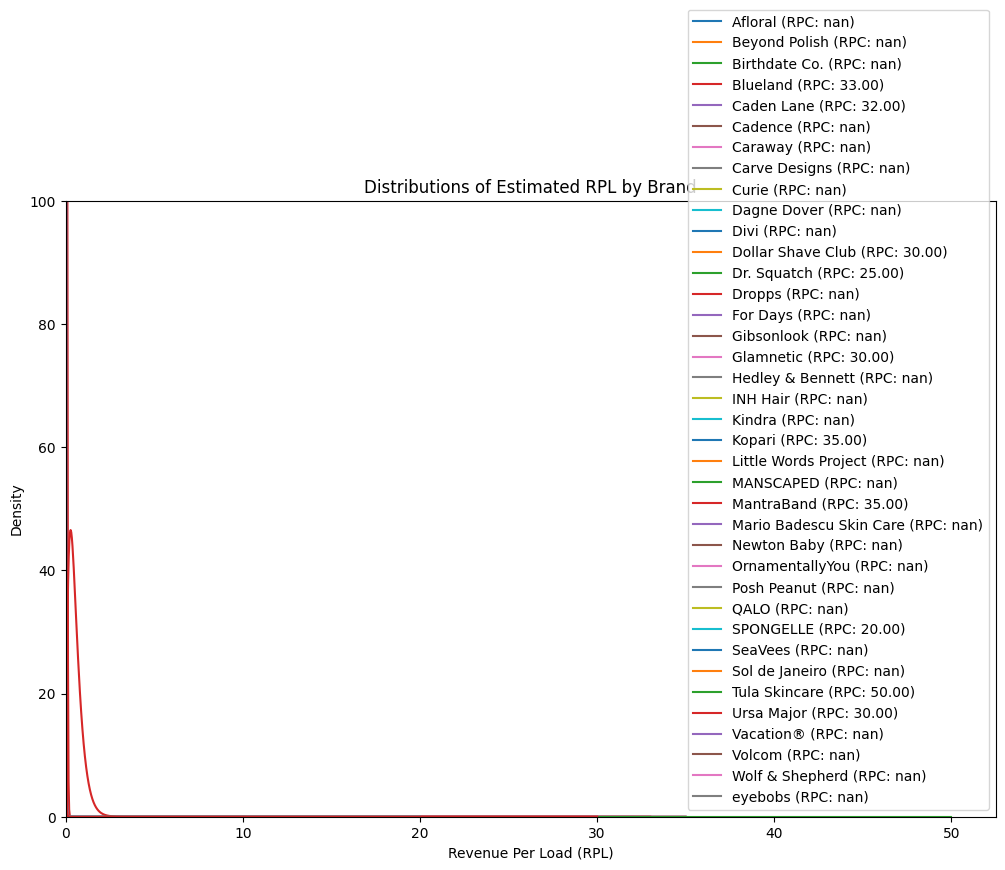

In [113]:
plt.figure(figsize=(12, 8))

# Assuming you have 'RPC' column correctly set up in df_top_pub_sorted
for _, row in df_top_pub.iterrows():
    # x values are conversion rates; we scale them by RPC to get RPL
    x_scaled = np.linspace(0, 1, 1000) * row['RPC']  # Scale x-values by RPC to convert CR to RPL
    
    # Calculate Beta PDF for original conversion rates
    y = beta.pdf(np.linspace(0, 1, 1000), row['alpha'], row['beta'])
    
    # Plot using scaled x-values (RPL) and original y-values (density)
    plt.plot(x_scaled, y, label=f"{row['BRAND_NAME']} (RPC: {row['RPC']:.2f})")

plt.title('Distributions of Estimated RPL by Brand')
plt.xlabel('Revenue Per Load (RPL)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, plt.xlim()[1])  # Adjust x-axis limit if necessary to focus on the relevant RPL range
plt.ylim(0, 100)  # Set y-axis limit to keep the density scale consistent
plt.show()